In [1]:
import json
import os
import time
import ipyparallel as ipp

import matplotlib.pyplot as plt
import torch
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [2]:
rc = ipp.Cluster(n=3).start_and_connect_sync()
rc.activate()

rc.ids 

dview = rc[:]

Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

In [3]:
%%px --targets all

import sys
import os
sys.path.append(os.getcwd())

seeds = [11,12,13,14,15]
learning_rates = [0.01, 0.1]

dfca_li = []
dfca_gi = []
ifca = []

In [4]:
seeds = [11,12]
learning_rates = [0.001, 0.01]

dfca_li = []
dfca_gi = []
ifca = []

Running the dfca-gi experiment

In [5]:
%%px --target 0 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_gi.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-GI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_gi.append(res_mean)



<AsyncResult(%px): pending>

Running the dfca-li experiment


In [6]:
%%px --target 1 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_li.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_li.append(res_mean)



<AsyncResult(%px): pending>

Running the ifca experiment

In [7]:
%%px --target 2 --noblock
import ifca as IFCA
import json
import time
import torch
import numpy as np

with open("config_ifca.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------IFCA, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = IFCA.TrainMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    ifca.append(res_mean)



<AsyncResult(%px): pending>

Experiment Final Results: 

In [8]:
rc.wait_interactive()
%pxresult
dfca_gi = rc[0].pull('dfca_gi', block=True)
dfca_li = rc[1].pull('dfca_li', block=True)
ifca = rc[2].pull('ifca', block=True)

unknown:   0%|          | 0/3 [00:00<?, ?tasks/s]

---------------------------------IFCA, lr: 0.001, seed: 11---------------------------------
config: {'m': 1200, 'm_test': 200, 'p': 4, 'n': 200, 'uneven': True, 'h1': 200, 'num_epochs': 5, 'batch_size': 100, 'tau': 10, 'lr': 0.001, 'data_seed': 11, 'train_seed': 11, 'config_override': '', 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 2.293 a 0.112 clct[440, 260, 363, 137] cl_acc 0.480  3.414sec
Epoch -1 tst: l 2.294 a 0.112 clct[74, 38, 65, 23] cl_acc 0.440  0.526sec
Epoch 0 tr: l 2.293 a 0.113 clct[436, 262, 360, 142] cl_acc 0.497  lr 0.001000 9.888sec(train) 4.263sec(infer)
Epoch 0 tst: l 2.293 a 0.113 clct[74, 37, 66, 23] cl_acc 0.445  0.916sec
result written at output_ifca/results.pickle
checkpoint written at output_ifca/checkpoint.pt
Epoch 1 tr: l 2.292 a 0.115 clct[432, 264, 358, 146] cl_acc 0.511  lr 0.001000 8.292sec(train) 5.823sec(infer)
Epoch 1 tst: l 2.292 a 0.116 clct[70, 36, 66, 28] cl_acc 0.470  1.112sec
Epoch 2 tr: l 2.291 a 0.118 clct[428, 257, 366, 1

{'test_loss': [[2.2927916038036344, 2.2918188273906708, 2.29081903219223, 2.2897985076904295, 2.288752930760384, 2.2876869839429856], [2.2927916038036344, 2.2826249474287033, 2.2703484833240513, 2.255801303386688, 2.2394405961036683, 2.221912010908127]], 'test_acc': [[0.12358749999999999, 0.1263375, 0.1294, 0.1324875, 0.137, 0.1398875], [0.12358749999999999, 0.15510000000000002, 0.1885875, 0.230825, 0.2764, 0.32518749999999996]], 'cl_acc': [[0.48750000000000004, 0.49750000000000005, 0.5175, 0.5375, 0.55, 0.5775], [0.48750000000000004, 0.6325000000000001, 0.7424999999999999, 0.8125, 0.845, 0.85]]}


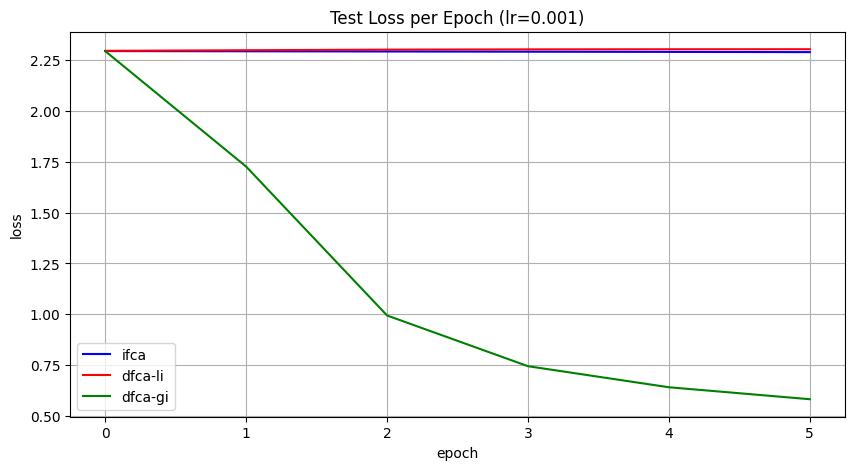

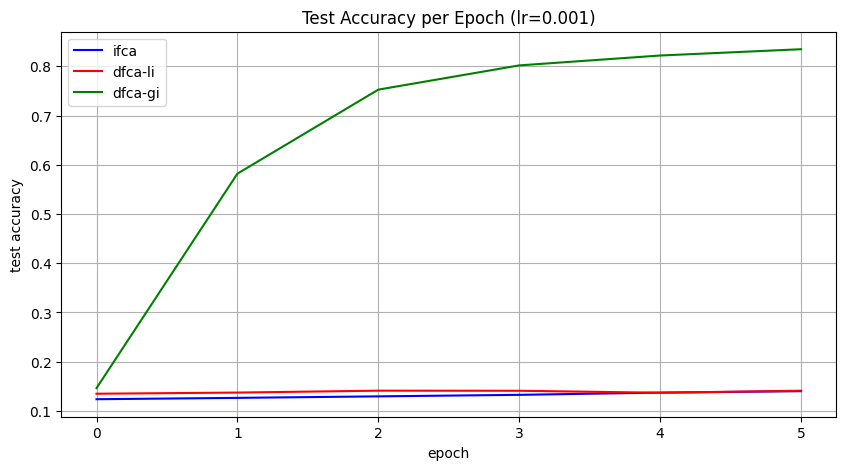

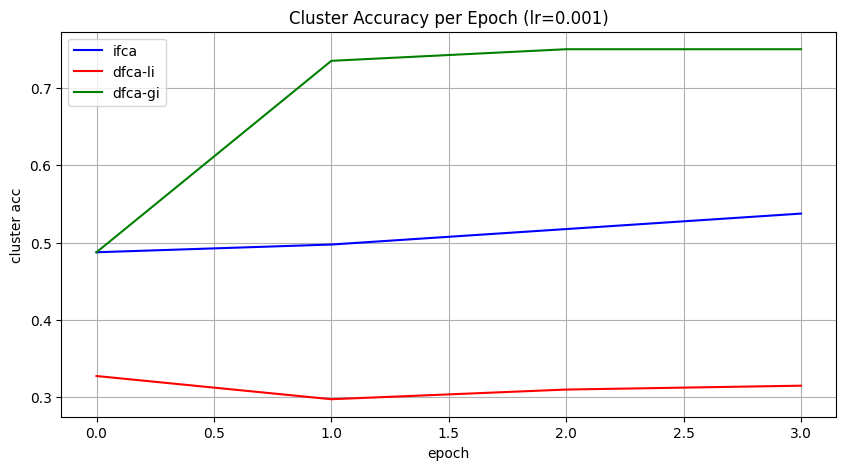

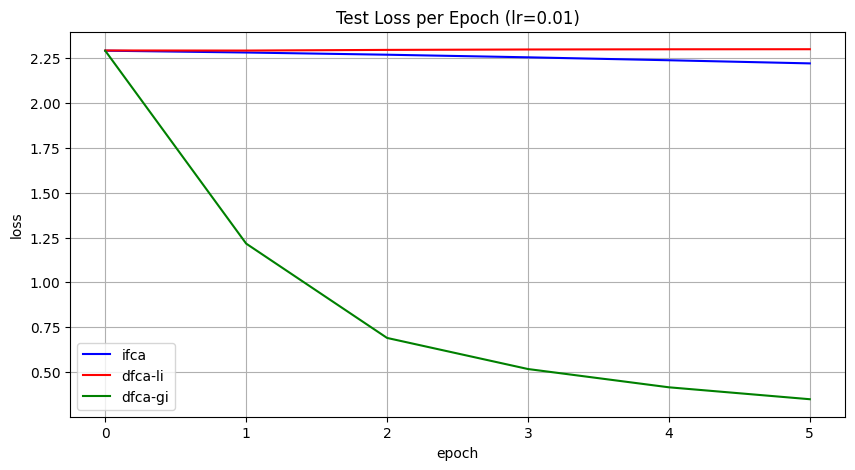

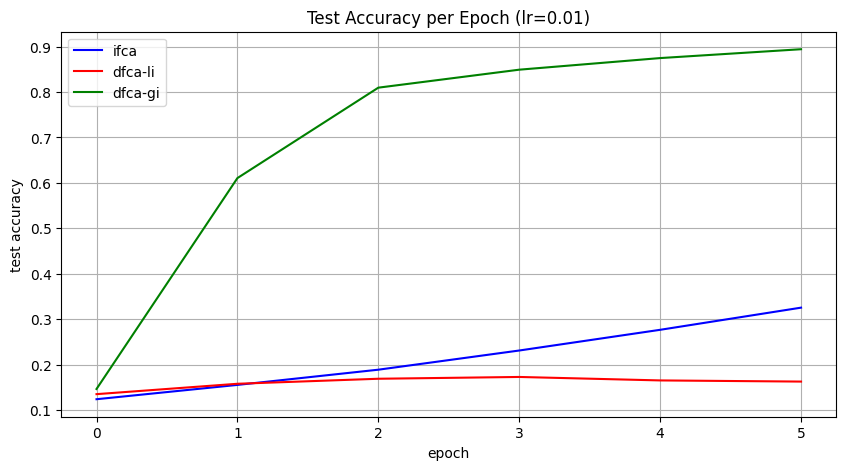

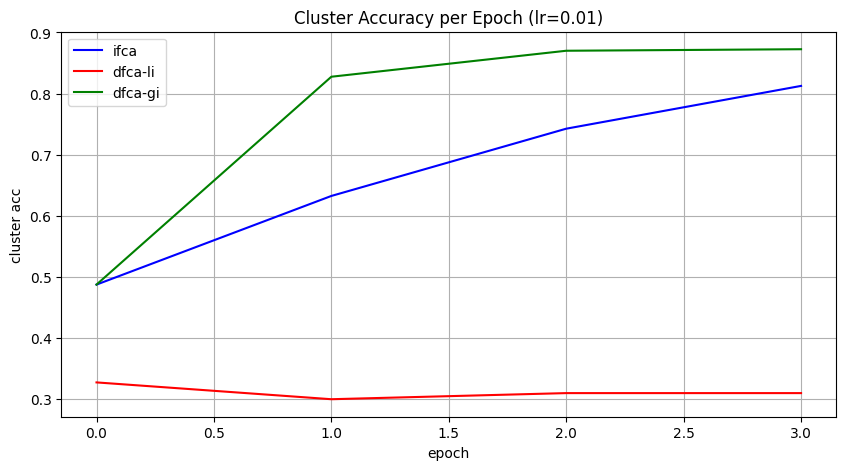

In [17]:

r_ifca = {}
r_dfca_gi = {}
r_dfca_li = {}

r_ifca['test_loss'] = []
r_ifca['test_acc'] = []
r_ifca['cl_acc'] = []
for i in range(len(learning_rates)):
    r_ifca['test_loss'].append(ifca[i][0])
    r_ifca['test_acc'].append(ifca[i][1])
    r_ifca['cl_acc'].append(ifca[i][2])

r_dfca_gi['test_loss'] = []
r_dfca_gi['test_acc'] = []
r_dfca_gi['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_gi['test_loss'].append(dfca_gi[i][0])
    r_dfca_gi['test_acc'].append(dfca_gi[i][1])
    r_dfca_gi['cl_acc'].append(dfca_gi[i][2])

r_dfca_li['test_loss'] = []
r_dfca_li['test_acc'] = []
r_dfca_li['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_li['test_loss'].append(dfca_li[i][0])
    r_dfca_li['test_acc'].append(dfca_li[i][1])
    r_dfca_li['cl_acc'].append(dfca_li[i][2])

print(r_ifca)

os.makedirs('graphs', exist_ok=True)

for l in range(len(learning_rates)):

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_loss'][l], label='ifca', color='blue')
    plt.plot(r_dfca_li['test_loss'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_loss'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Test Loss per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'train_loss.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_acc'][l], label='ifca', color='blue')
    plt.plot(r_dfca_li['test_acc'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_acc'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('test accuracy')
    plt.title(f'Test Accuracy per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'test_acc.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['cl_acc'][l][:4], label='ifca', color='blue')
    plt.plot(r_dfca_li['cl_acc'][l][:4], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['cl_acc'][l][:4], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('cluster acc')
    plt.title(f'Cluster Accuracy per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'cluster_acc.png'))